In [3]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Hyperparameters
cuda = True
epochs = 20
log_interval = 400
batchSize = 16

hidden_layer_sizes = [256, 256, 256, 256, 256, 256, 256, 256, 256, 256]

lr = 0.001

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc_in = nn.Linear(3 * 32 * 32, hidden_layer_sizes[0])
        self.bn1 = nn.BatchNorm1d(hidden_layer_sizes[0])
        self.linears = nn.ModuleList([nn.Linear(hidden_layer_sizes[i], hidden_layer_sizes[i+1]) for i in range(len(hidden_layer_sizes) - 1)])
        self.bns = nn.ModuleList([nn.BatchNorm1d(hidden_layer_sizes[i]) for i in range(len(hidden_layer_sizes) - 1)])
        self.fc_out = nn.Linear(hidden_layer_sizes[-1], 10)
        
#         for i, l in enumerate(self.linears):
#             self.linears[i].weight.data.copy_(torch.eye(self.linears[i].weight.size(0)))

    def forward(self, x):
        activations = []
        x = x.view(-1, 3 * 32 * 32)
        x = F.relu(self.fc_in(x))
        activations = np.expand_dims(torch.sign(x).cpu().data.numpy(), axis=1)
        x = self.bn1(x)
        for i, l in enumerate(self.linears):
            x = F.relu(l(x))
            activations = np.append(activations, np.expand_dims(torch.sign(x).cpu().data.numpy(), axis=1), axis=1)
            x = self.bns[i](x)
        x = self.fc_out(x)
        return x, activations
    
model = Net()
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

Net (
  (fc_in): Linear (3072 -> 256)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True)
  (linears): ModuleList (
    (0): Linear (256 -> 256)
    (1): Linear (256 -> 256)
    (2): Linear (256 -> 256)
    (3): Linear (256 -> 256)
    (4): Linear (256 -> 256)
    (5): Linear (256 -> 256)
    (6): Linear (256 -> 256)
    (7): Linear (256 -> 256)
    (8): Linear (256 -> 256)
  )
  (bns): ModuleList (
    (0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True)
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True)
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True)
    (7): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True)
    (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True)
  )
  (fc

In [6]:
class ActivationFollower():
    
    train_activations = 0
    train_labels = 0
    test_activations = 0
    test_labels = 0
    
    def __init__(self):
        train_activations = 0
        train_labels = 0
        test_activations = 0
        test_labels = 0
    
    def reset(self):
        train_activations = 0
        train_labels = 0
        test_activations = 0
        test_labels = 0
    
    def train_add(self, x, y):
        if type(self.train_activations) is np.ndarray:
            self.train_activations = np.append(self.train_activations, x, axis=0)
            self.train_labels = np.append(self.train_labels, y, axis=0)
        else:
            self.train_activations = x
            self.train_labels = y
    
    def test_add(self, x, y):
        if type(self.test_activations) is np.ndarray:
            self.test_activations = np.append(self.test_activations, x, axis=0)
            self.test_labels = np.append(self.test_labels, y, axis=0)
        else:
            self.test_activations = x
            self.test_labels = y
        
    def print_metrics(self):
        bins = np.arange(0, 1.1, 0.1)
        proba_activate_layer = []
        for i in range(len(hidden_layer_sizes)):
            proba_activate_layer += [np.where(self.train_activations[:,i] == 0., 1, 0).mean(0)]
            
        data = np.vstack(proba_activate_layer).T
        plt.figure(figsize=(20,10))
        plt.hist(data, bins, label=['Layer : {}'.format(i) for i in range(1, len(proba_activate_layer) + 1)])
        plt.legend()
        plt.title('Histogram of probability of activation')
        plt.show()
        # Here sample and compute histogram of distances.
        # Then Matrix with std of distances between classes.
        

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [8]:
if cuda:
    model.cuda()
    criterion.cuda()

In [11]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(trainloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output, activations = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.data[0]))

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in testloader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output, activations = model(data)
        test_loss += criterion(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(testloader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    
def activation_metrics():
    metrics = ActivationFollower()
    for batch_idx, (data, target) in enumerate(trainloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output, activations = model(data)
        metrics.train_add(activations, target.cpu().data.numpy())
        if batch_idx > 500:
            break
#     for batch_idx, (data, target) in enumerate(testloader):
#         if cuda:
#             data, target = data.cuda(), target.cuda()
#         data, target = Variable(data), Variable(target)
#         output, activations = model(data)
#         metrics.test_add(activations, target.cpu().data.numpy())
        
    metrics.print_metrics()

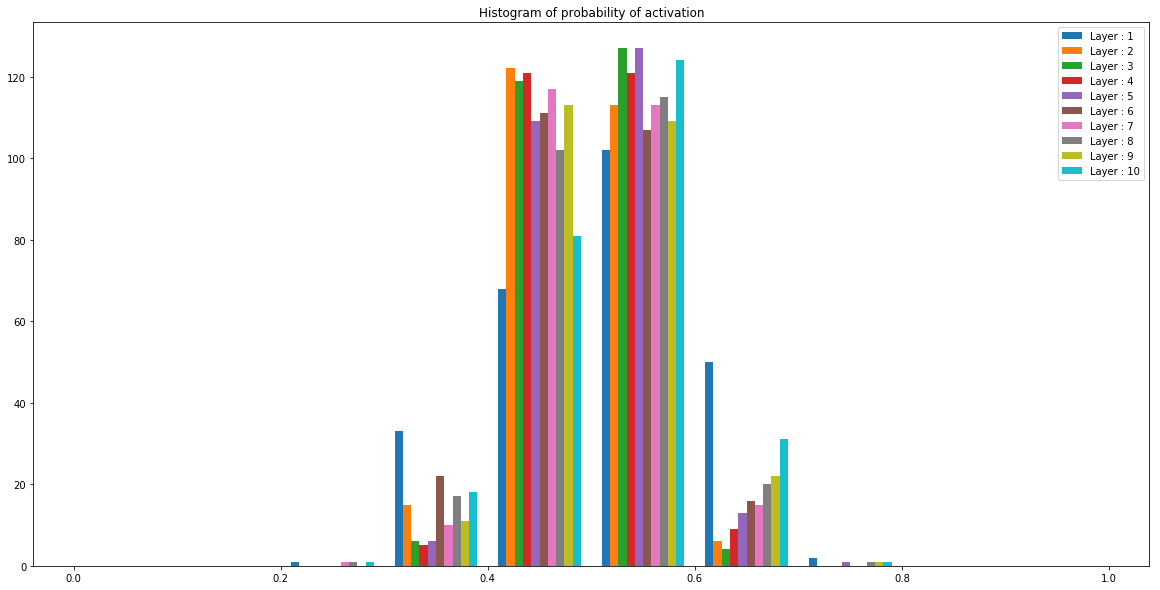

Train Epoch: 1 [0/50000 (0%)]	Loss: 1.235714
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.619915
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.725274
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.462773
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.634778
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.870055
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.920171
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.391827

Test set: Average loss: 1.4932, Accuracy: 4845/10000 (48%)



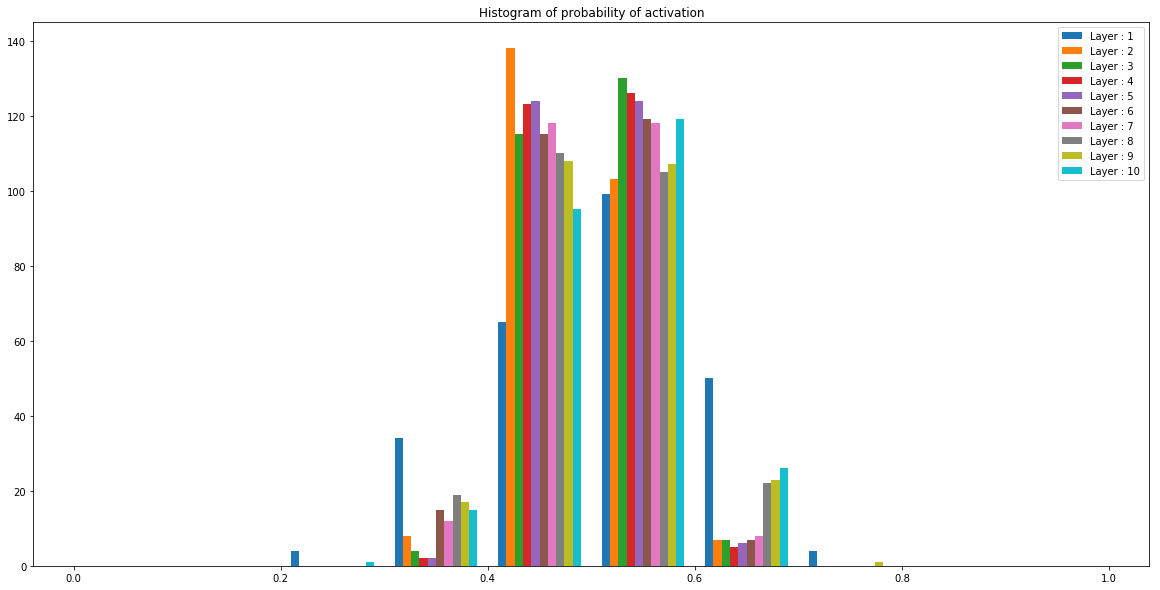

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.102990
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.414784
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.679049
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.269114
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.657749
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.141469
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.773717
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.731173

Test set: Average loss: 1.4732, Accuracy: 4902/10000 (49%)



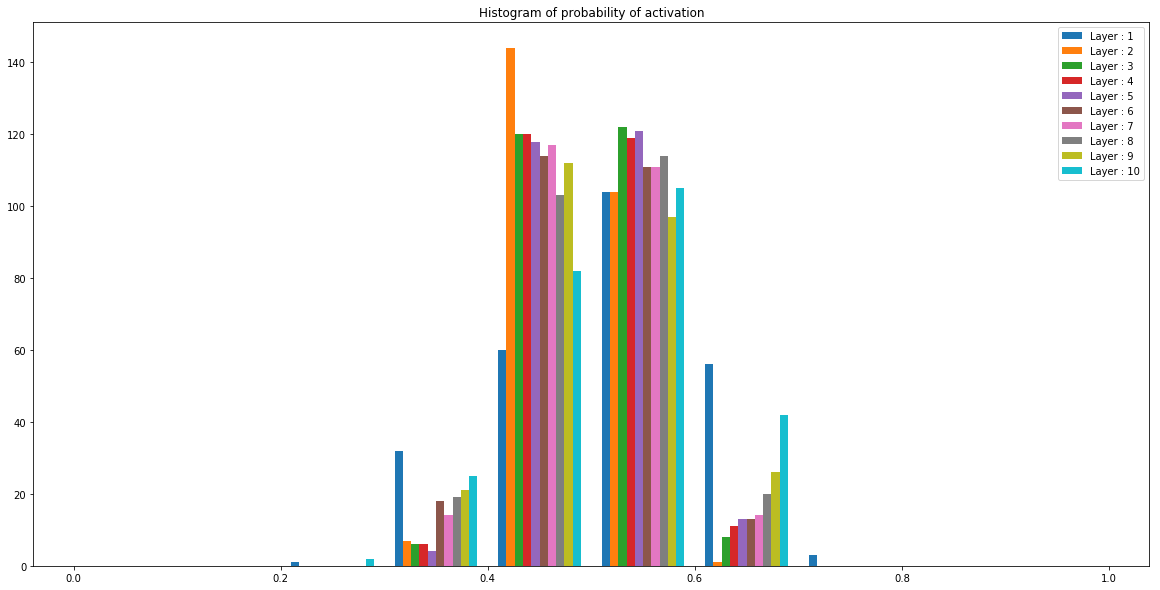

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.915594
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.385741
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.361272
Train Epoch: 3 [19200/50000 (38%)]	Loss: 1.500723
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.439751
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.224510
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.690434
Train Epoch: 3 [44800/50000 (90%)]	Loss: 1.662731

Test set: Average loss: 1.4707, Accuracy: 4938/10000 (49%)



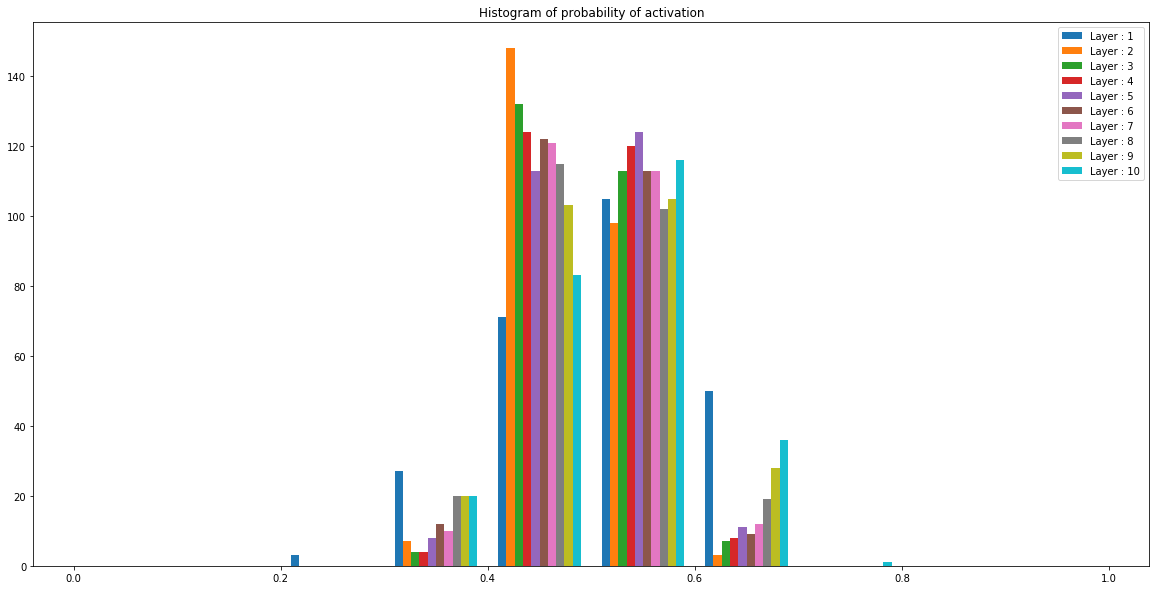

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.366568
Train Epoch: 4 [6400/50000 (13%)]	Loss: 1.605678
Train Epoch: 4 [12800/50000 (26%)]	Loss: 2.015628
Train Epoch: 4 [19200/50000 (38%)]	Loss: 1.666421
Train Epoch: 4 [25600/50000 (51%)]	Loss: 1.005721
Train Epoch: 4 [32000/50000 (64%)]	Loss: 1.687056
Train Epoch: 4 [38400/50000 (77%)]	Loss: 1.330800
Train Epoch: 4 [44800/50000 (90%)]	Loss: 1.607226

Test set: Average loss: 1.4398, Accuracy: 5048/10000 (50%)



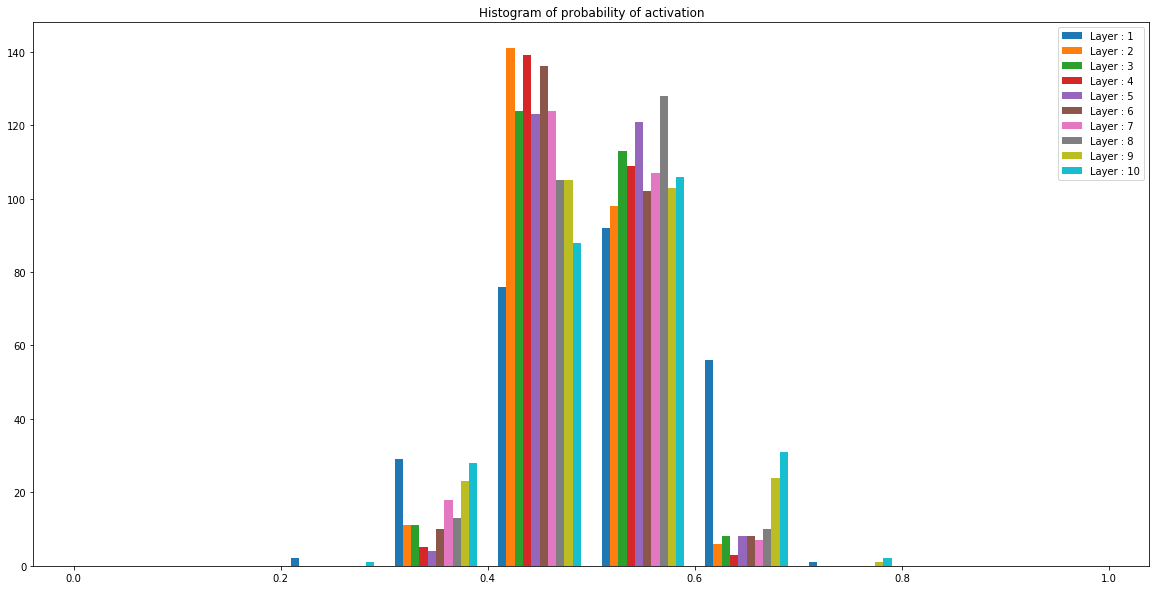

Train Epoch: 5 [0/50000 (0%)]	Loss: 1.298227
Train Epoch: 5 [6400/50000 (13%)]	Loss: 1.496729
Train Epoch: 5 [12800/50000 (26%)]	Loss: 1.275990
Train Epoch: 5 [19200/50000 (38%)]	Loss: 1.588213
Train Epoch: 5 [25600/50000 (51%)]	Loss: 1.623709
Train Epoch: 5 [32000/50000 (64%)]	Loss: 1.310200
Train Epoch: 5 [38400/50000 (77%)]	Loss: 1.290883
Train Epoch: 5 [44800/50000 (90%)]	Loss: 1.496407

Test set: Average loss: 1.4315, Accuracy: 5176/10000 (52%)



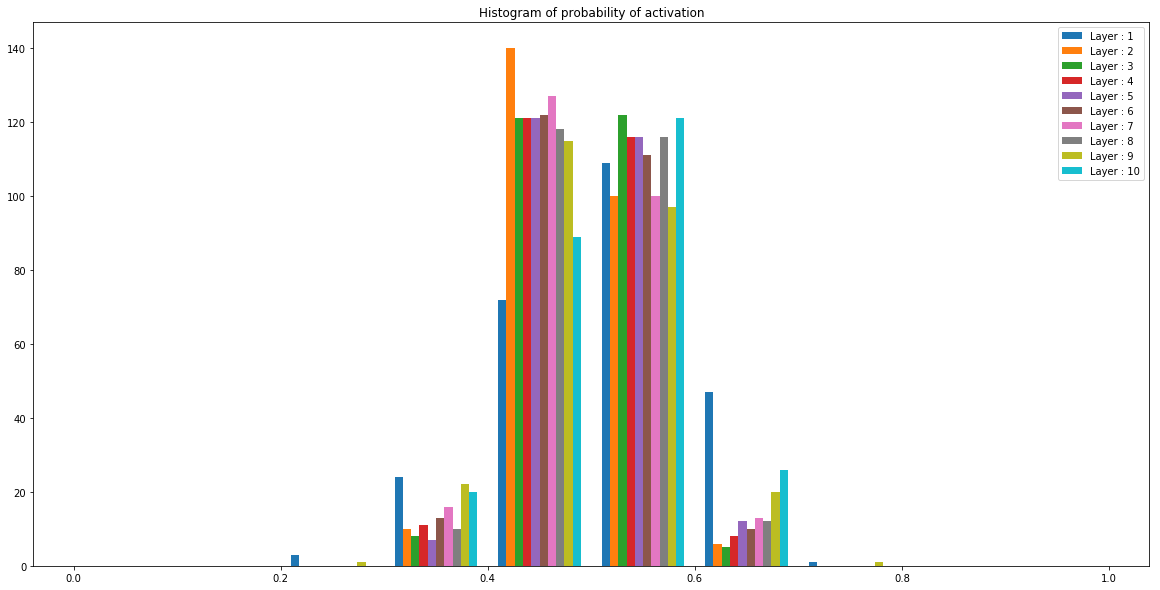

Train Epoch: 6 [0/50000 (0%)]	Loss: 1.406861
Train Epoch: 6 [6400/50000 (13%)]	Loss: 1.404142
Train Epoch: 6 [12800/50000 (26%)]	Loss: 1.382667
Train Epoch: 6 [19200/50000 (38%)]	Loss: 1.254134
Train Epoch: 6 [25600/50000 (51%)]	Loss: 1.065683
Train Epoch: 6 [32000/50000 (64%)]	Loss: 1.182971
Train Epoch: 6 [38400/50000 (77%)]	Loss: 1.417468
Train Epoch: 6 [44800/50000 (90%)]	Loss: 1.997206

Test set: Average loss: 1.4120, Accuracy: 5163/10000 (52%)



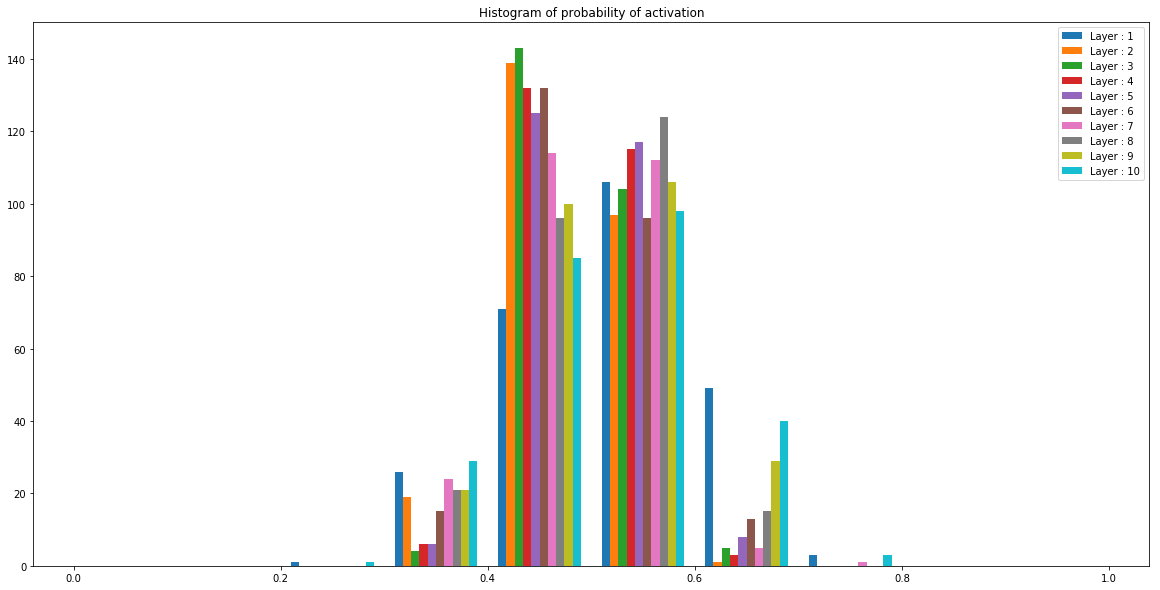

Train Epoch: 7 [0/50000 (0%)]	Loss: 1.300475
Train Epoch: 7 [6400/50000 (13%)]	Loss: 1.366084
Train Epoch: 7 [12800/50000 (26%)]	Loss: 1.715819
Train Epoch: 7 [19200/50000 (38%)]	Loss: 1.261724
Train Epoch: 7 [25600/50000 (51%)]	Loss: 1.506602
Train Epoch: 7 [32000/50000 (64%)]	Loss: 1.295224
Train Epoch: 7 [38400/50000 (77%)]	Loss: 1.134051
Train Epoch: 7 [44800/50000 (90%)]	Loss: 1.106041

Test set: Average loss: 1.4100, Accuracy: 5116/10000 (51%)



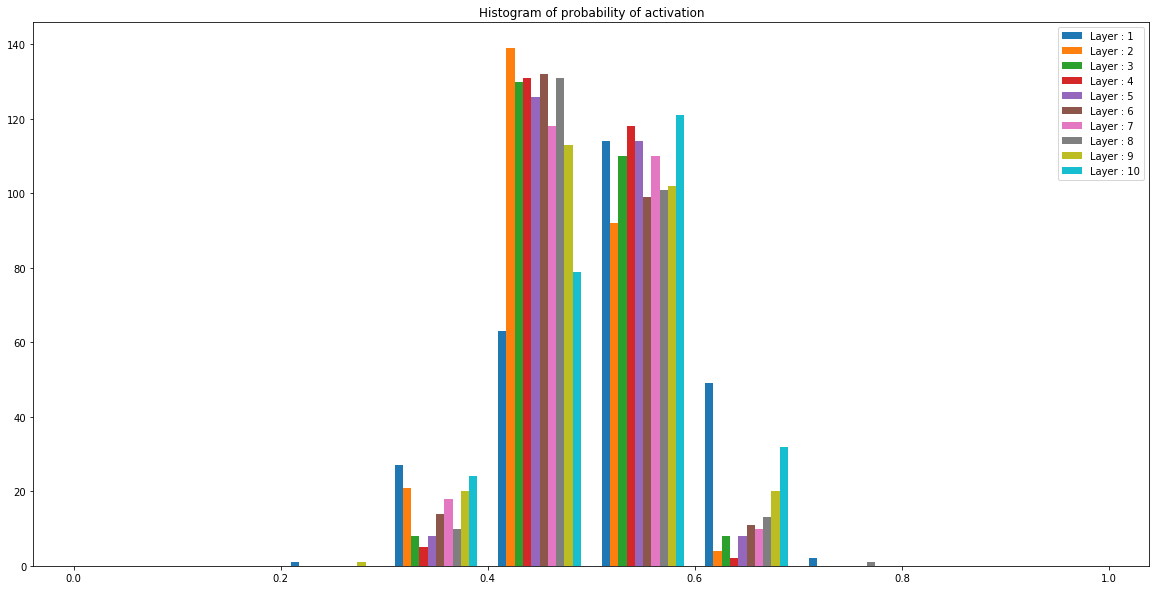

Train Epoch: 8 [0/50000 (0%)]	Loss: 1.516708
Train Epoch: 8 [6400/50000 (13%)]	Loss: 1.227789
Train Epoch: 8 [12800/50000 (26%)]	Loss: 1.284232
Train Epoch: 8 [19200/50000 (38%)]	Loss: 1.450541
Train Epoch: 8 [25600/50000 (51%)]	Loss: 0.936306
Train Epoch: 8 [32000/50000 (64%)]	Loss: 1.066900
Train Epoch: 8 [38400/50000 (77%)]	Loss: 1.689691
Train Epoch: 8 [44800/50000 (90%)]	Loss: 1.397592

Test set: Average loss: 1.3919, Accuracy: 5161/10000 (52%)



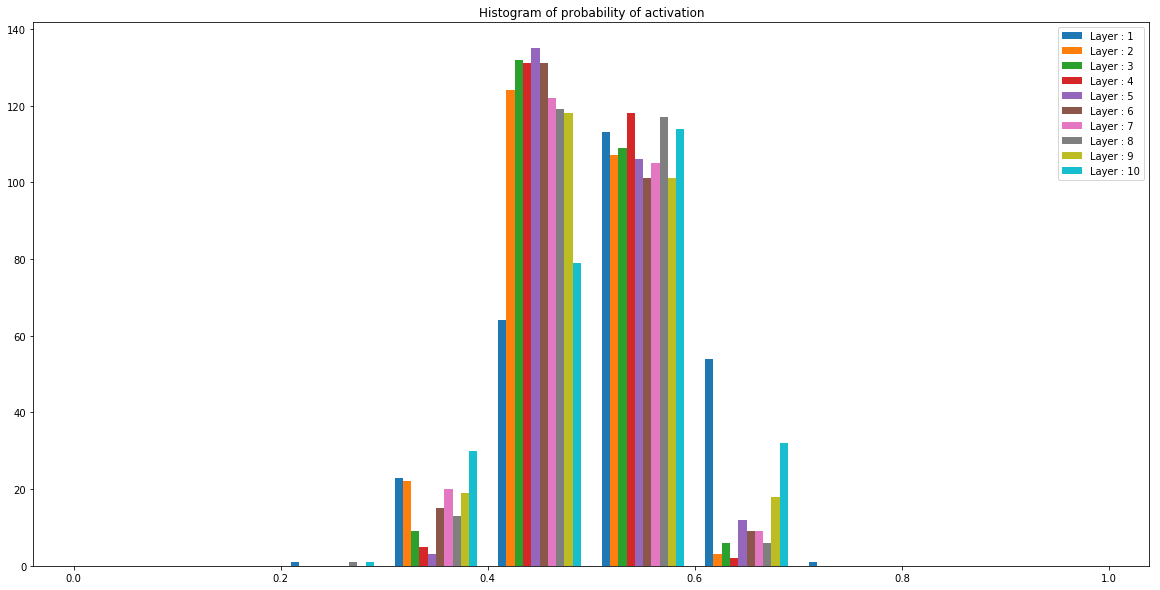

Train Epoch: 9 [0/50000 (0%)]	Loss: 1.507963
Train Epoch: 9 [6400/50000 (13%)]	Loss: 1.045194
Train Epoch: 9 [12800/50000 (26%)]	Loss: 1.659054
Train Epoch: 9 [19200/50000 (38%)]	Loss: 1.358791
Train Epoch: 9 [25600/50000 (51%)]	Loss: 1.313525
Train Epoch: 9 [32000/50000 (64%)]	Loss: 1.324982
Train Epoch: 9 [38400/50000 (77%)]	Loss: 1.702972
Train Epoch: 9 [44800/50000 (90%)]	Loss: 1.202053

Test set: Average loss: 1.3892, Accuracy: 5307/10000 (53%)



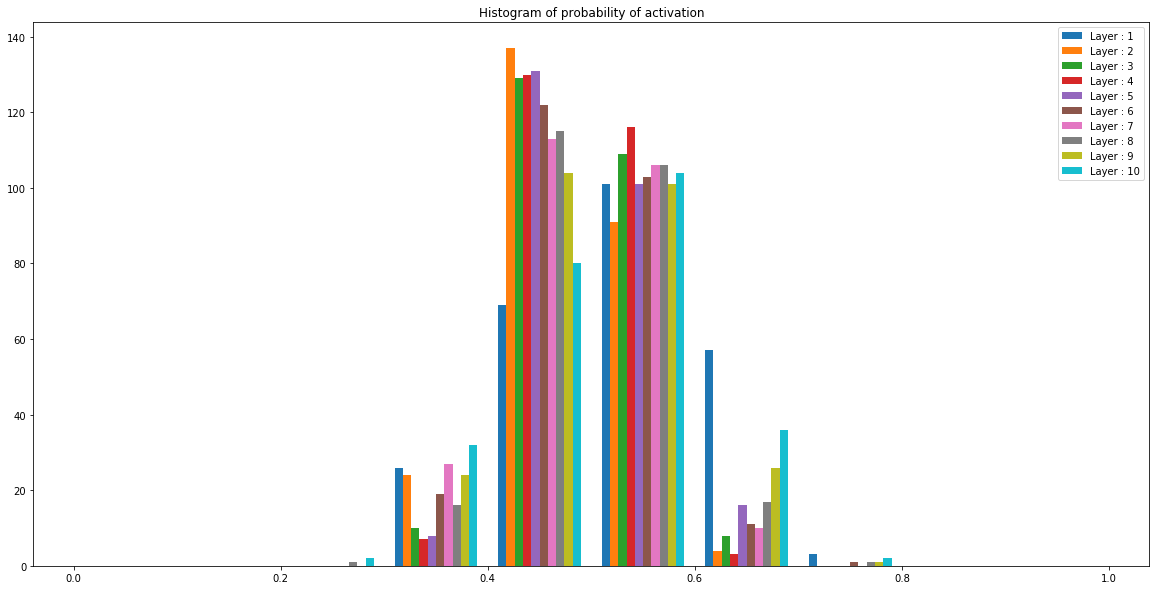

Train Epoch: 10 [0/50000 (0%)]	Loss: 1.605855
Train Epoch: 10 [6400/50000 (13%)]	Loss: 1.391548
Train Epoch: 10 [12800/50000 (26%)]	Loss: 1.765239
Train Epoch: 10 [19200/50000 (38%)]	Loss: 1.341192
Train Epoch: 10 [25600/50000 (51%)]	Loss: 1.120136
Train Epoch: 10 [32000/50000 (64%)]	Loss: 1.071580
Train Epoch: 10 [38400/50000 (77%)]	Loss: 1.363405
Train Epoch: 10 [44800/50000 (90%)]	Loss: 1.995714

Test set: Average loss: 1.3754, Accuracy: 5275/10000 (53%)



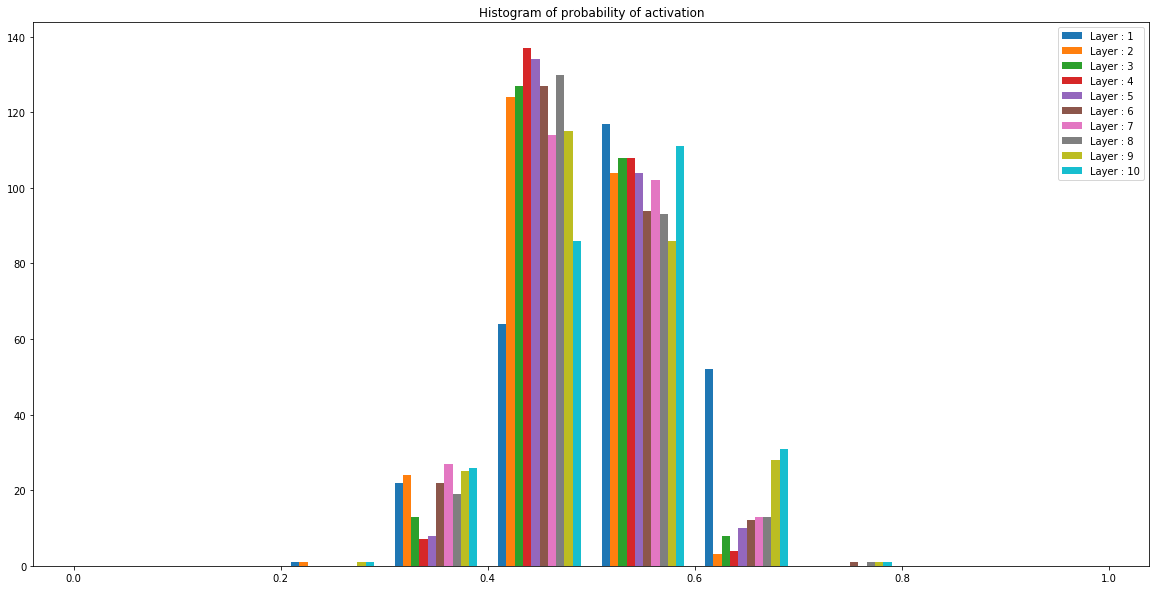

Train Epoch: 11 [0/50000 (0%)]	Loss: 1.097410
Train Epoch: 11 [6400/50000 (13%)]	Loss: 0.909298
Train Epoch: 11 [12800/50000 (26%)]	Loss: 1.119078
Train Epoch: 11 [19200/50000 (38%)]	Loss: 1.381562
Train Epoch: 11 [25600/50000 (51%)]	Loss: 1.288574
Train Epoch: 11 [32000/50000 (64%)]	Loss: 1.494577
Train Epoch: 11 [38400/50000 (77%)]	Loss: 1.452897
Train Epoch: 11 [44800/50000 (90%)]	Loss: 0.817545

Test set: Average loss: 1.3770, Accuracy: 5277/10000 (53%)



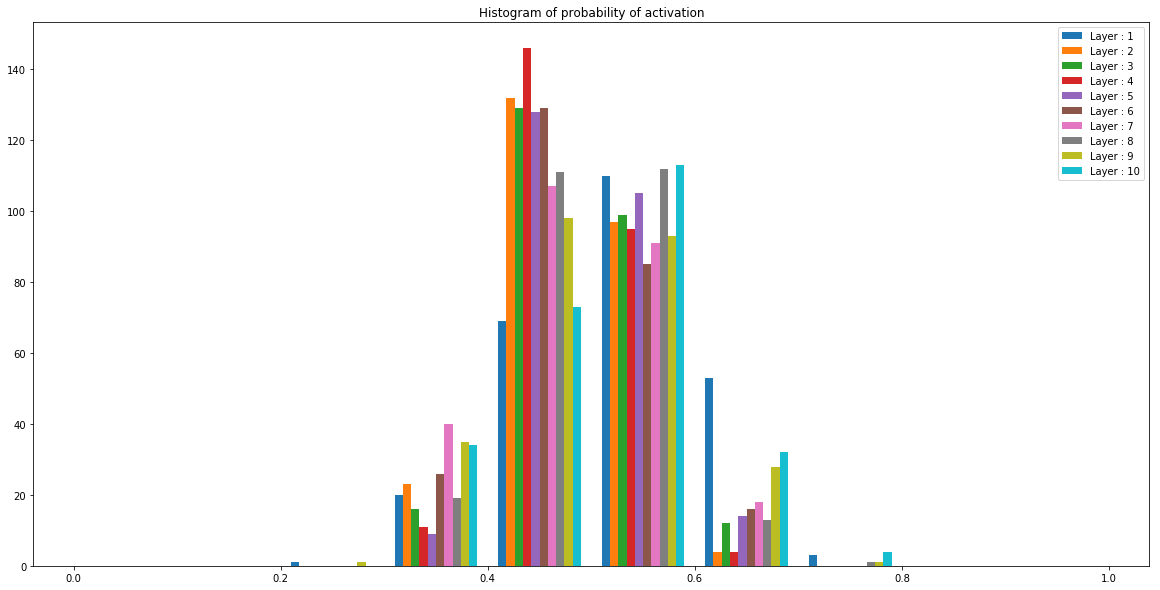

Train Epoch: 12 [0/50000 (0%)]	Loss: 1.220159
Train Epoch: 12 [6400/50000 (13%)]	Loss: 1.159328
Train Epoch: 12 [12800/50000 (26%)]	Loss: 1.066855
Train Epoch: 12 [19200/50000 (38%)]	Loss: 1.268918
Train Epoch: 12 [25600/50000 (51%)]	Loss: 1.540381
Train Epoch: 12 [32000/50000 (64%)]	Loss: 0.980309
Train Epoch: 12 [38400/50000 (77%)]	Loss: 0.738942
Train Epoch: 12 [44800/50000 (90%)]	Loss: 1.290216

Test set: Average loss: 1.3703, Accuracy: 5259/10000 (53%)



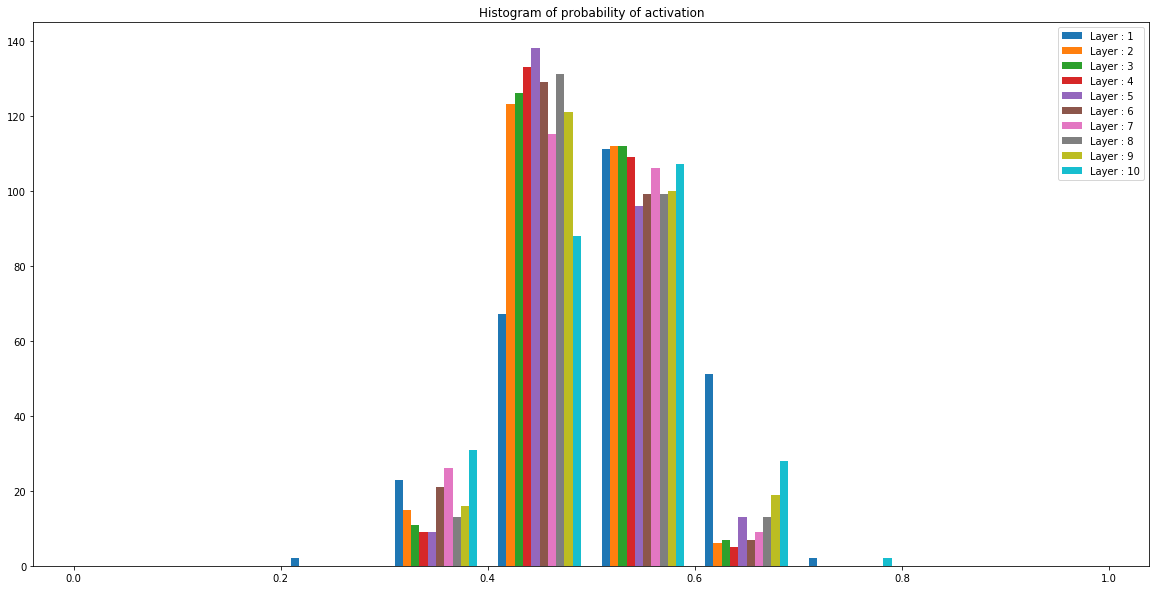

Train Epoch: 13 [0/50000 (0%)]	Loss: 1.398590
Train Epoch: 13 [6400/50000 (13%)]	Loss: 1.685052
Train Epoch: 13 [12800/50000 (26%)]	Loss: 1.035450
Train Epoch: 13 [19200/50000 (38%)]	Loss: 2.246044
Train Epoch: 13 [25600/50000 (51%)]	Loss: 1.329134
Train Epoch: 13 [32000/50000 (64%)]	Loss: 0.842509
Train Epoch: 13 [38400/50000 (77%)]	Loss: 1.146252
Train Epoch: 13 [44800/50000 (90%)]	Loss: 1.584840

Test set: Average loss: 1.3460, Accuracy: 5386/10000 (54%)



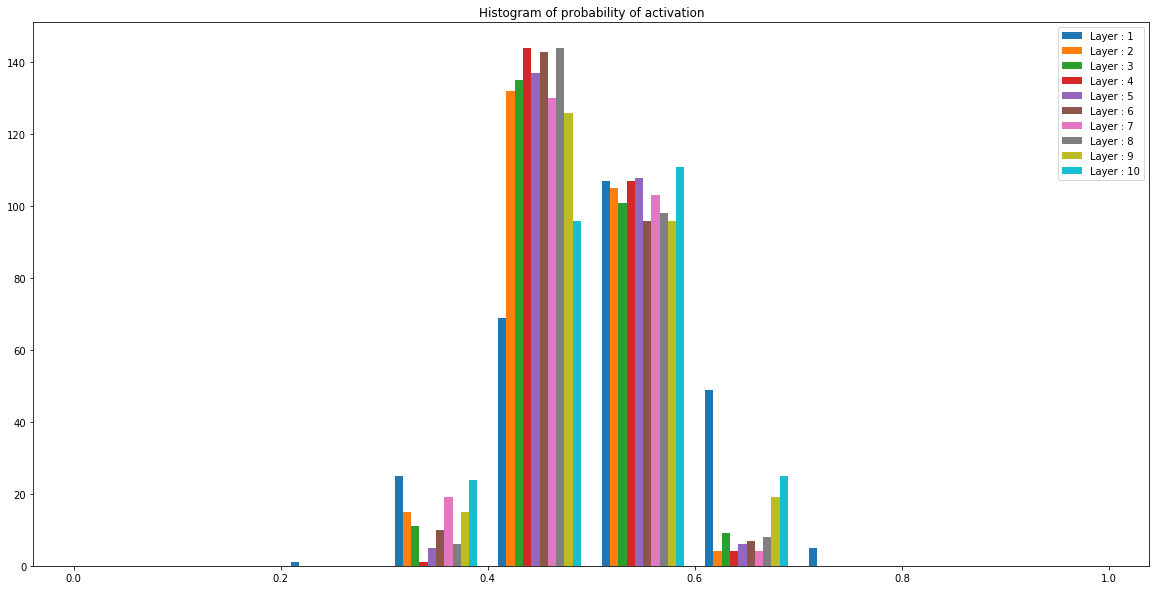

Train Epoch: 14 [0/50000 (0%)]	Loss: 1.114812
Train Epoch: 14 [6400/50000 (13%)]	Loss: 1.412326
Train Epoch: 14 [12800/50000 (26%)]	Loss: 0.981493
Train Epoch: 14 [19200/50000 (38%)]	Loss: 1.231456
Train Epoch: 14 [25600/50000 (51%)]	Loss: 1.492610
Train Epoch: 14 [32000/50000 (64%)]	Loss: 1.194468
Train Epoch: 14 [38400/50000 (77%)]	Loss: 1.647698
Train Epoch: 14 [44800/50000 (90%)]	Loss: 1.484636


Process Process-110:
Process Process-109:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self.run()
    self._target(*self._args, **self._kwargs)
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/lucas/anaconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 45, in _worker_loop
    self._target(*self._args, **self._kwargs)
  File "/home/lucas/anaconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 35, in _worker_loop
    data_queue.put((idx, samples))
    r = index_queue.get()
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/queues.py", line 378, in get
    return

KeyboardInterrupt: 

  File "/home/lucas/anaconda2/lib/python2.7/pickle.py", line 554, in save_tuple
    save(element)
  File "/home/lucas/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/home/lucas/anaconda2/lib/python2.7/pickle.py", line 606, in save_list
    self._batch_appends(iter(obj))
  File "/home/lucas/anaconda2/lib/python2.7/pickle.py", line 639, in _batch_appends
    save(x)
  File "/home/lucas/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/home/lucas/anaconda2/lib/python2.7/multiprocessing/forking.py", line 67, in dispatcher
    self.save_reduce(obj=obj, *rv)
  File "/home/lucas/anaconda2/lib/python2.7/pickle.py", line 400, in save_reduce
    save(func)
  File "/home/lucas/anaconda2/lib/python2.7/pickle.py", line 286, in save
    f(self, obj) # Call unbound method with explicit self
  File "/home/lucas/anaconda2/lib/python2.7/pickle.py", line 748, in 

In [12]:
activation_metrics()

for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    activation_metrics()